In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64
epochs = 100  # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 modelini yükle (transfer öğrenme)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 268s 930ms/step - accuracy: 0.7263 - loss: 0.8893 - val_accuracy: 0.8536 - val_loss: 0.3920
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 879ms/step - accuracy: 0.8399 - loss: 0.4561 - val_accuracy: 0.8675 - val_loss: 0.3637
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 876ms/step - accuracy: 0.8505 - loss: 0.4183 - val_accuracy: 0.8595 - val_loss: 0.3668
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 875ms/step - accuracy: 0.8478 - loss: 0.4122 - val_accuracy: 0.8620 - val_loss: 0.3642
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 243s 882ms/step - accuracy: 0.8533 - loss: 0.3995 - val_accuracy: 0.8723 - val_loss: 0.3484
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 879ms/step - accuracy: 0.8549 - loss: 0.3980 - val_accuracy: 0.8720 - val_loss: 0.3532
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 243s 883ms/step - accuracy: 0.8578 - loss: 0.3865 - val_accuracy: 0.8750 - val_loss: 0.3488
Epoch 8/100
275/27

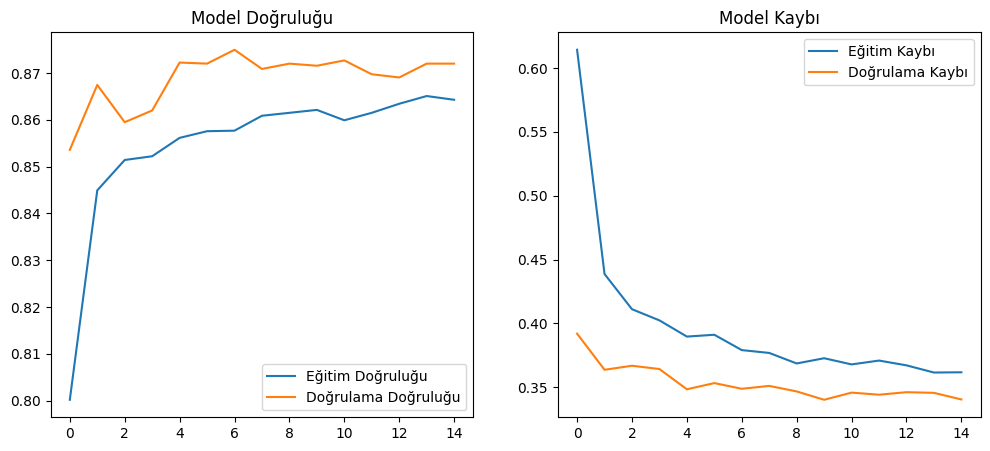

In [3]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━

Attention

In [5]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Activation

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = tf.reduce_max
        self.dense1 = Dense(units=1, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(units=1, kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, -1))
        self.add = Add()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()

    def call(self, inputs):
        channel = inputs.shape[-1]
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        
        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        avg_pool = self.dense1(avg_pool)
        max_pool = self.dense1(max_pool)
        
        avg_pool = self.dense2(avg_pool)
        max_pool = self.dense2(max_pool)
        
        # Add and Sigmoid
        channel_attention = self.add([avg_pool, max_pool])
        channel_attention = self.activation(channel_attention)
        
        return self.multiply([inputs, channel_attention])

In [6]:
from tensorflow.keras.layers import Conv2D, Concatenate

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.concat = Concatenate(axis=-1)
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')
        self.multiply = Multiply()

    def call(self, inputs):
        # Average Pooling and Max Pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate along the channel axis
        concat = self.concat([avg_pool, max_pool])
        
        # Convolution layer
        spatial_attention = self.conv(concat)
        
        return self.multiply([inputs, spatial_attention])

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 modelini yükle (transfer öğrenme)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Input layer
inputs = Input(shape=(224, 224, 3))

# ResNet50 modelini kullan
x = base_model(inputs)

# Channel Attention ekle
x = ChannelAttention(ratio=8)(x)

# Spatial Attention ekle
x = SpatialAttention(kernel_size=7)(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)  # Sınıf sayısı

# Modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_with_attention.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 252s 876ms/step - accuracy: 0.6938 - loss: 0.9285 - val_accuracy: 0.8591 - val_loss: 0.3862
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 875ms/step - accuracy: 0.8416 - loss: 0.4444 - val_accuracy: 0.8634 - val_loss: 0.3653
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 240s 873ms/step - accuracy: 0.8514 - loss: 0.4145 - val_accuracy: 0.8663 - val_loss: 0.3536
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 243s 884ms/step - accuracy: 0.8525 - loss: 0.4004 - val_accuracy: 0.8698 - val_loss: 0.3498
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 880ms/step - accuracy: 0.8555 - loss: 0.3899 - val_accuracy: 0.8657 - val_loss: 0.3483
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 878ms/step - accuracy: 0.8596 - loss: 0.3786 - val_accuracy: 0.8718 - val_loss: 0.3427
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 880ms/step - accuracy: 0.8604 - loss: 0.3743 - val_accuracy: 0.8741 - val_loss: 0.3451
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 876ms/step - accuracy: 

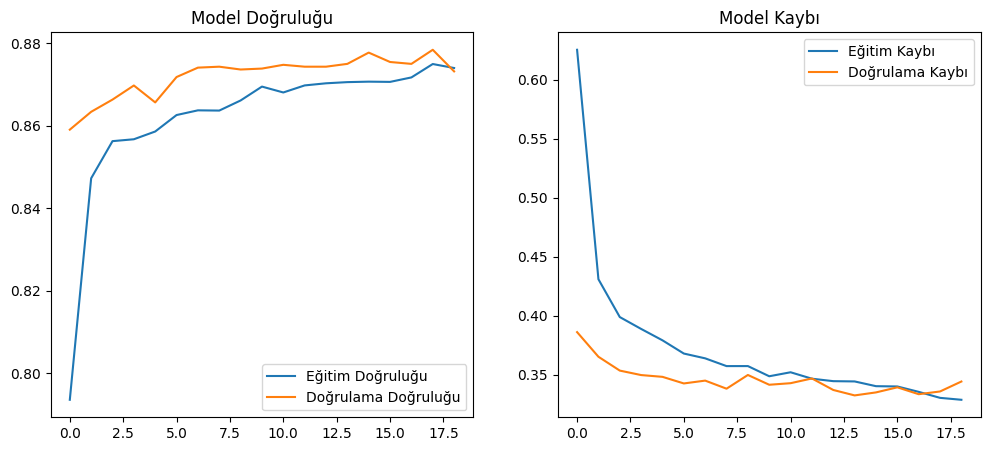

In [8]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━